# Packages

In [ ]:
#%% packages
import numpy as np
import scipy
import pandas as pd
import pprint
import joblib
from functools import partial

import warnings
warnings.filterwarnings("ignore")

from xgboost import XGBRegressor, DMatrix
from sklearn.model_selection import KFold

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

import sys
import os
from pathlib import Path
import pickle as pkl

from function_train_xgb import *

# Working directory

In [ ]:
project_dir = Path("F:/13 Gapfill_since_2017/")
project_dir.mkdir(exist_ok=True)
site = "BART_AmeriFlux"
site_data_dir = project_dir / site
site_data_dir.mkdir(exist_ok=True)
save_dir = site_data_dir / "FC_XGB_models"
save_dir.mkdir(exist_ok=True)
data_train_test_dir = site_data_dir / "FC_data_train_test"
sys.path.append(site_data_dir)
os.chdir(site_data_dir)
cwd = os.getcwd()
print("Current working directory: ", cwd)
print(site_data_dir)

Current working directory:  f:\13 Gapfill_since_2017\BART_AmeriFlux
F:\13 Gapfill_since_2017\BART_AmeriFlux


In [ ]:
print(site_data_dir)
learning_curve_dir = site_data_dir / "FC_learning_curve"
learning_curve_dir.mkdir(exist_ok=True)
# test perforamnce
test_performance_dir = site_data_dir / "FC_test_performance"
test_performance_dir.mkdir(exist_ok=True)
all_prediction_dir = site_data_dir / "FC_accurate_prediction"
all_prediction_dir.mkdir(exist_ok=True)
test_prediction_dir = site_data_dir / "FC_test_prediction"
test_prediction_dir.mkdir(exist_ok=True)
test_prediction_dir

F:\13 Gapfill_since_2017\BART_AmeriFlux
F:\13 Gapfill_since_2017\BART_AmeriFlux\FC_train_performance


# Input features and targest variable

In [ ]:
predictor_subsets = {
        "03_GCC+Base": ['TIMESTAMP_END', 'GCC', 'Tair_f', 'Tsoil', 'VPD_f', 'PPFD_DIF', 'PPFD_DIR', 'PPFD_f', 'DOY_sin', 'DOY_cos']
}   
y_col = 'NEE_50._orig'

subset_columns = ['TIMESTAMP_END', 'GCC', 'Tair_f', 'Tsoil', 'VPD_f', 'PPFD_DIF', 'PPFD_DIR', 'PPFD_f', 'DOY_sin', 'DOY_cos']

# Search space

In [30]:
# Define the parameter grid
parameters = {
    "objective": ["reg:squarederror"],
    "learning_rate": [0.00001, 0.001, 0.01, 0.1, 0.3],
    "max_depth": [3, 5, 7],
    "min_child_weight": [3, 5, 7],
    "subsample": [0.6, 0.8],
    "reg_lambda": [0, 0.1, 1, 10],
    "reg_alpha": [0, 0.1, 1, 10],
    "n_estimators": [50, 100, 250]
}

# Load site data 2017-2022

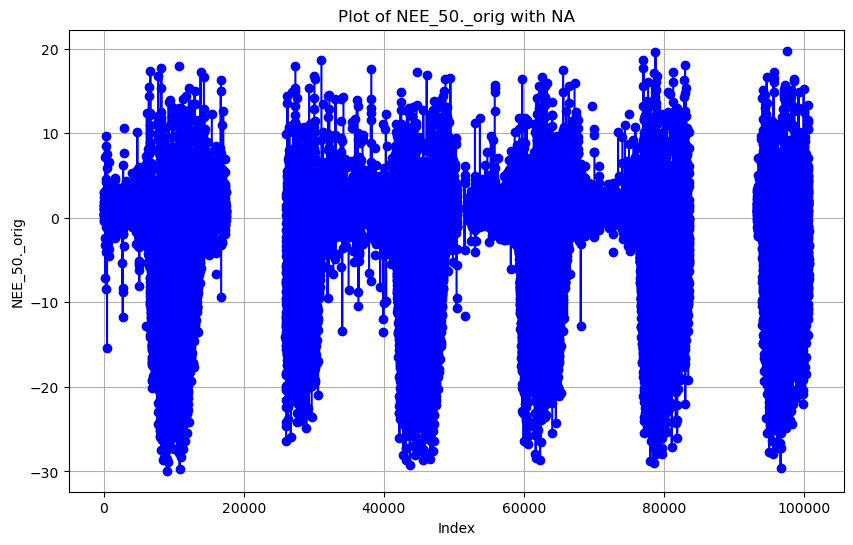

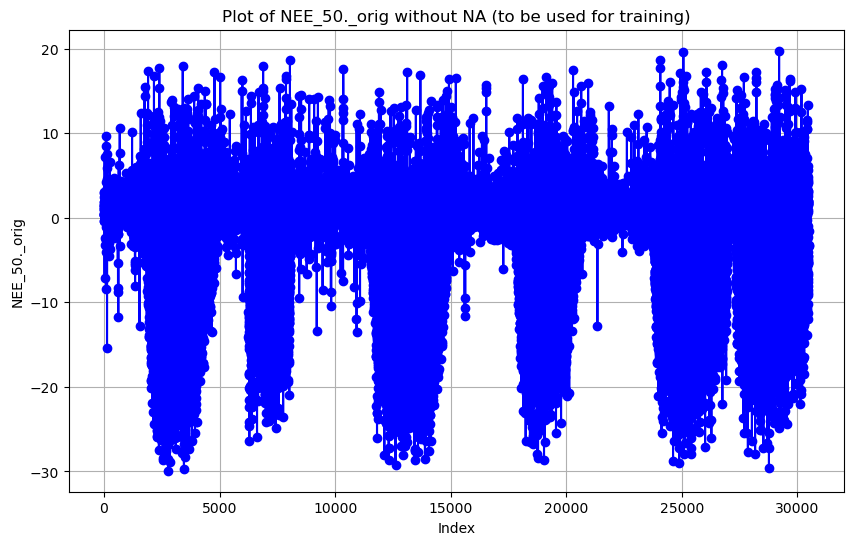

In [31]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Set the working directory

# Read the data from the CSV file
site_data = pd.read_csv(site_data_dir/ "data_for_XGB_BART_AmeriFlux.csv")

# Define the column to be plotted
y_col = 'NEE_50._orig'

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(site_data[y_col].values, marker='o', linestyle='-', color='b')
plt.title(f'Plot of {y_col} with NA')
plt.xlabel('Index')
plt.ylabel(y_col)
plt.grid(True)
plt.show()

# Drop rows with missing values in the specified column
site_data_no_na = site_data.dropna(subset=[y_col]) # use this dataset to find the best hyperparameter

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(site_data_no_na[y_col].values, marker='o', linestyle='-', color='b')
plt.title(f'Plot of {y_col} without NA (to be used for training)')
plt.xlabel('Index')
plt.ylabel(y_col)
plt.grid(True)
plt.show()

# Step 1: find the best hyperparameters

In [34]:
X = site_data_no_na[subset_columns]
y = site_data_no_na[y_col]
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Create XGBoost regressor model
model = XGBRegressor()

# Create GridSearchCV object
xgb_grid = GridSearchCV(
    estimator=model,
    param_grid=parameters,
    cv=10,
    verbose=1,
    scoring='neg_mean_squared_error',
    n_jobs = 10
)

# Fit GridSearchCV to the data
xgb_grid.fit(X, y)

# Print the cross-validation scores for each set of hyperparameters
print("Cross-validation scores:")
cv_results = xgb_grid.cv_results_
for mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
    print(f"Mean Score: {mean_score}, Parameters: {params}")

# Transferring the best parameters to a new XGBoost regressor
best_params = xgb_grid.best_params_
print(best_params)
reg = XGBRegressor(random_state=42, booster='gbtree', tree_method='hist',
                   n_jobs=50, **best_params)
print(reg)

# Save model object as pkl
model_path = save_dir / "model.pkl"
with open(model_path, 'wb') as f:
    pkl.dump(reg, f)

print(f"Model pkl file saved to {model_path}.")

# Save hyperparameters as CSV
csv_file = save_dir / 'best_params_gridCV.csv'
import csv
# Write dictionary data to CSV file
with open(csv_file, mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['parameter', 'value'])  # Write header
    for param, value in best_params.items():
        writer.writerow([param, value])
print(f'Data has been written to {csv_file}')

Fitting 10 folds for each of 4320 candidates, totalling 43200 fits
Cross-validation scores:
Mean Score: -71.27318078773365, Parameters: {'learning_rate': 1e-05, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 50, 'objective': 'reg:squarederror', 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.6}
Mean Score: -71.27312637856762, Parameters: {'learning_rate': 1e-05, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 50, 'objective': 'reg:squarederror', 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.8}
Mean Score: -71.27318178824522, Parameters: {'learning_rate': 1e-05, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 50, 'objective': 'reg:squarederror', 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 0.6}
Mean Score: -71.27312810809556, Parameters: {'learning_rate': 1e-05, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 50, 'objective': 'reg:squarederror', 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 0.8}
Mean Score: -71.27320675685057, Parameters: {'learning_r

# Step 2: fit/train the model (10 fold CV)

## accurate prediction using all data

In [ ]:
import pickle as pickle
site_data =  add_time_vars(site_data)
site_data_no_na =  add_time_vars(site_data_no_na)

for subset_name, subset_features in predictor_subsets.items():
    print(subset_name)
    model_path = (save_dir ) /"bayes"/ "model.pkl"
    print(model_path)
    with open(model_path, 'rb') as f:
        reg = pickle.load(f)
    print(reg)

    X = site_data_no_na[subset_features]
    y = site_data_no_na[y_col] 
    reg.fit(X, y)

    X_all = site_data[subset_features]
    y_pred = reg.predict(X_all)
    site_data['XGB_NEE_U50_fall'] = y_pred 
    site_data['XGB_NEE_U50_f'] = np.where(site_data[y_col].notnull(), site_data[y_col], site_data['XGB_NEE_U50_fall'])
    site_data.to_csv(all_prediction_dir / ('_prediction.csv'))

03_GCC+Base
F:\13 Gapfill_since_2017\BART_AmeriFlux\FC_XGB_models\bayes\model.pkl
XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9983422819350287, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.020446024638744845,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1780, n_jobs=50, num_parallel_tree=None,
             predictor=None, random_state=42, ...)


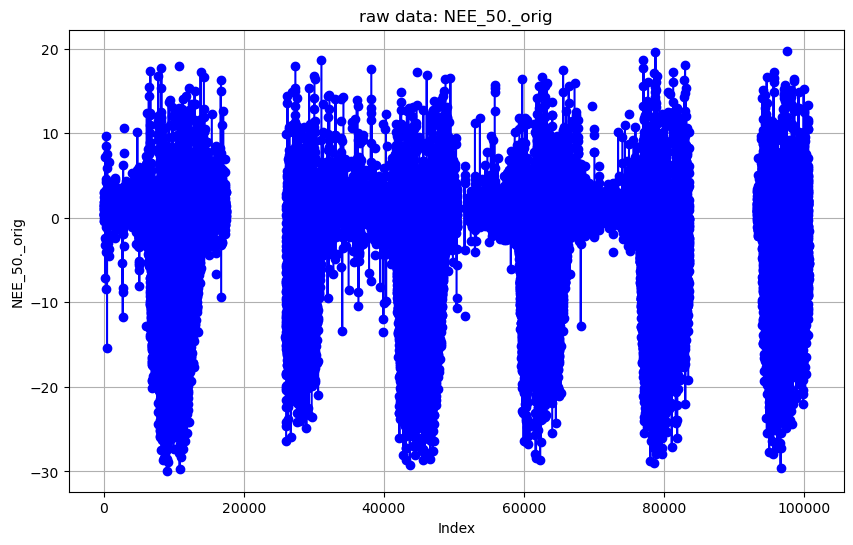

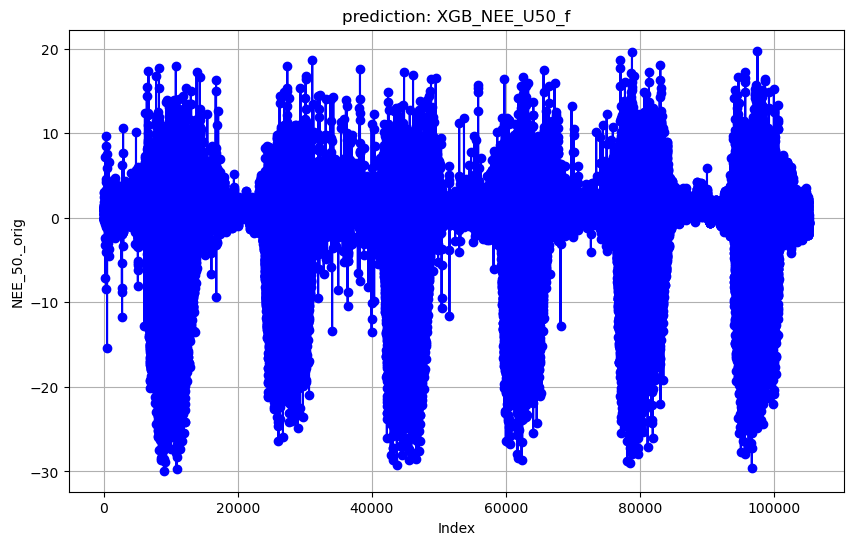

In [57]:
plt.figure(figsize=(10, 6))
plt.plot(site_data[y_col].values, marker='o', linestyle='-', color='b')
plt.title(f'raw data: {y_col}')
plt.xlabel('Index')
plt.ylabel(y_col)
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(site_data["XGB_NEE_U50_f"].values, marker='o', linestyle='-', color='b')
plt.title('prediction: XGB_NEE_U50_f')
plt.xlabel('Index')
plt.ylabel(y_col)
plt.grid(True)
plt.show()

# Step 3: learning curve (10 test set)

F:\13 Gapfill_since_2017\BART_AmeriFlux\FC_data_train_test
03_GCC+Base
F:\13 Gapfill_since_2017\BART_AmeriFlux\FC_XGB_models\bayes\model.pkl
XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9983422819350287, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.020446024638744845,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1780, n_jobs=50, num_parallel_tree=None,
             predictor=None, random_state=42, ...)
[0]	validation_0-rmse:8.28793	validation_1-rmse:8.38249
[1]	validation_0-rmse:8.14156	vali

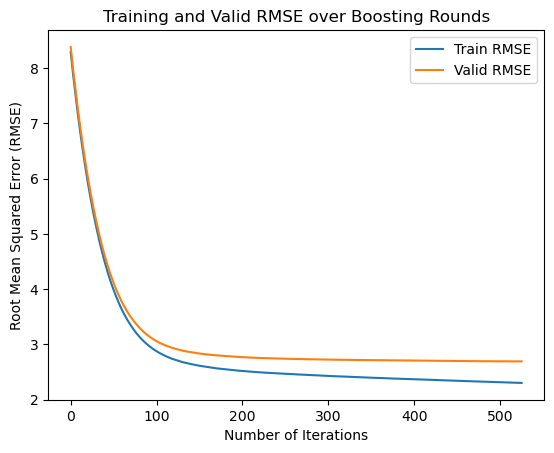

[0]	validation_0-rmse:8.31855	validation_1-rmse:8.10808
[1]	validation_0-rmse:8.17188	validation_1-rmse:7.96546
[2]	validation_0-rmse:8.02757	validation_1-rmse:7.82506
[3]	validation_0-rmse:7.88634	validation_1-rmse:7.68832
[4]	validation_0-rmse:7.75116	validation_1-rmse:7.55591
[5]	validation_0-rmse:7.61859	validation_1-rmse:7.42730
[6]	validation_0-rmse:7.48683	validation_1-rmse:7.29901
[7]	validation_0-rmse:7.36073	validation_1-rmse:7.17717
[8]	validation_0-rmse:7.23480	validation_1-rmse:7.05497
[9]	validation_0-rmse:7.11198	validation_1-rmse:6.93577
[10]	validation_0-rmse:6.99220	validation_1-rmse:6.81951
[11]	validation_0-rmse:6.87493	validation_1-rmse:6.70562
[12]	validation_0-rmse:6.76071	validation_1-rmse:6.59347
[13]	validation_0-rmse:6.65047	validation_1-rmse:6.48650
[14]	validation_0-rmse:6.54282	validation_1-rmse:6.38167
[15]	validation_0-rmse:6.43597	validation_1-rmse:6.27809
[16]	validation_0-rmse:6.33361	validation_1-rmse:6.17951
[17]	validation_0-rmse:6.23177	validation

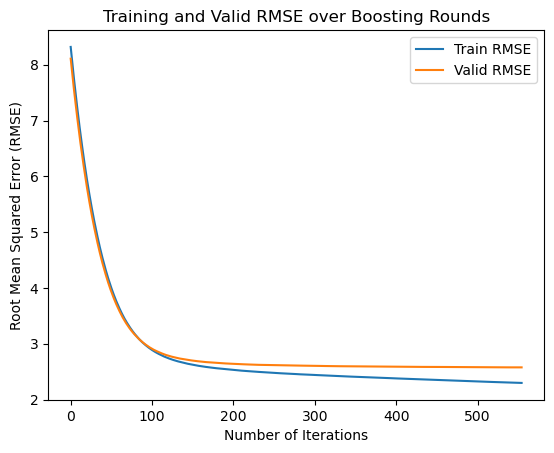

[0]	validation_0-rmse:8.28072	validation_1-rmse:8.44716
[1]	validation_0-rmse:8.13487	validation_1-rmse:8.29740
[2]	validation_0-rmse:7.99112	validation_1-rmse:8.14996
[3]	validation_0-rmse:7.85072	validation_1-rmse:8.00568
[4]	validation_0-rmse:7.71720	validation_1-rmse:7.86909
[5]	validation_0-rmse:7.58528	validation_1-rmse:7.73497
[6]	validation_0-rmse:7.45434	validation_1-rmse:7.60095
[7]	validation_0-rmse:7.32911	validation_1-rmse:7.47407
[8]	validation_0-rmse:7.20450	validation_1-rmse:7.34639
[9]	validation_0-rmse:7.08301	validation_1-rmse:7.22202
[10]	validation_0-rmse:6.96390	validation_1-rmse:7.10003
[11]	validation_0-rmse:6.84742	validation_1-rmse:6.98070
[12]	validation_0-rmse:6.73329	validation_1-rmse:6.86294
[13]	validation_0-rmse:6.62364	validation_1-rmse:6.75083
[14]	validation_0-rmse:6.51698	validation_1-rmse:6.64088
[15]	validation_0-rmse:6.41095	validation_1-rmse:6.53243
[16]	validation_0-rmse:6.30891	validation_1-rmse:6.42772
[17]	validation_0-rmse:6.20770	validation

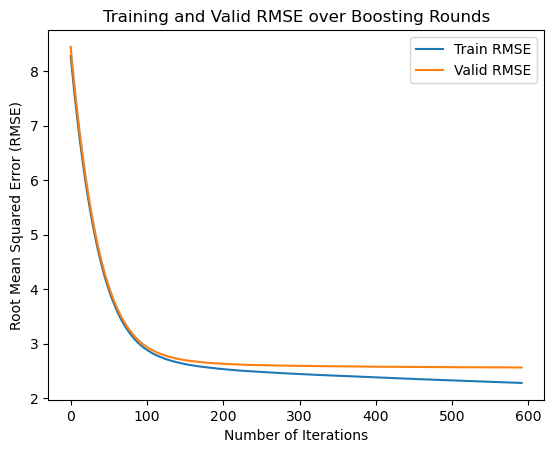

[0]	validation_0-rmse:8.30171	validation_1-rmse:8.25876
[1]	validation_0-rmse:8.15471	validation_1-rmse:8.11206
[2]	validation_0-rmse:8.01085	validation_1-rmse:7.96842
[3]	validation_0-rmse:7.87046	validation_1-rmse:7.82806
[4]	validation_0-rmse:7.73571	validation_1-rmse:7.69442
[5]	validation_0-rmse:7.60448	validation_1-rmse:7.56383
[6]	validation_0-rmse:7.47396	validation_1-rmse:7.43370
[7]	validation_0-rmse:7.34836	validation_1-rmse:7.30840
[8]	validation_0-rmse:7.22320	validation_1-rmse:7.18358
[9]	validation_0-rmse:7.10123	validation_1-rmse:7.06181
[10]	validation_0-rmse:6.98153	validation_1-rmse:6.94237
[11]	validation_0-rmse:6.86420	validation_1-rmse:6.82572
[12]	validation_0-rmse:6.75046	validation_1-rmse:6.71264
[13]	validation_0-rmse:6.64012	validation_1-rmse:6.60282
[14]	validation_0-rmse:6.53266	validation_1-rmse:6.49633
[15]	validation_0-rmse:6.42615	validation_1-rmse:6.39064
[16]	validation_0-rmse:6.32391	validation_1-rmse:6.28944
[17]	validation_0-rmse:6.22232	validation

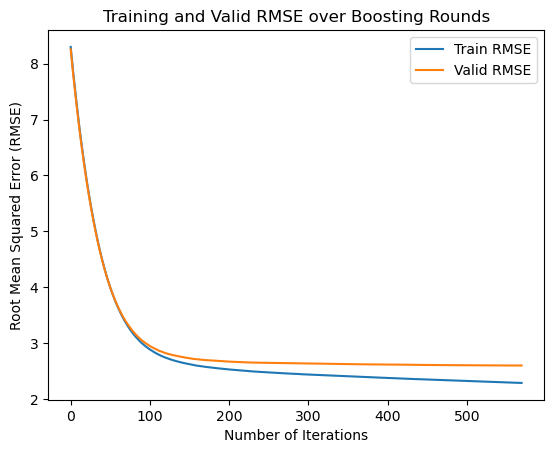

[0]	validation_0-rmse:8.30888	validation_1-rmse:8.19085
[1]	validation_0-rmse:8.16250	validation_1-rmse:8.04777
[2]	validation_0-rmse:8.01867	validation_1-rmse:7.90677
[3]	validation_0-rmse:7.87763	validation_1-rmse:7.76828
[4]	validation_0-rmse:7.74272	validation_1-rmse:7.63614
[5]	validation_0-rmse:7.61083	validation_1-rmse:7.50569
[6]	validation_0-rmse:7.47943	validation_1-rmse:7.37740
[7]	validation_0-rmse:7.35339	validation_1-rmse:7.25282
[8]	validation_0-rmse:7.22800	validation_1-rmse:7.13048
[9]	validation_0-rmse:7.10528	validation_1-rmse:7.01071
[10]	validation_0-rmse:6.98540	validation_1-rmse:6.89307
[11]	validation_0-rmse:6.86858	validation_1-rmse:6.77944
[12]	validation_0-rmse:6.75412	validation_1-rmse:6.66762
[13]	validation_0-rmse:6.64343	validation_1-rmse:6.55982
[14]	validation_0-rmse:6.53611	validation_1-rmse:6.45577
[15]	validation_0-rmse:6.43033	validation_1-rmse:6.35330
[16]	validation_0-rmse:6.32817	validation_1-rmse:6.25456
[17]	validation_0-rmse:6.22627	validation

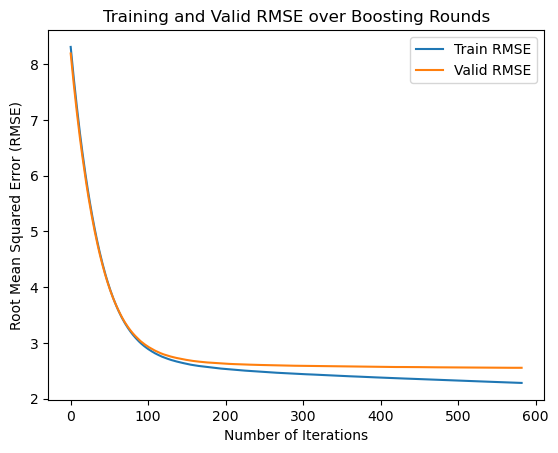

[0]	validation_0-rmse:8.30309	validation_1-rmse:8.24613
[1]	validation_0-rmse:8.15673	validation_1-rmse:8.10218
[2]	validation_0-rmse:8.01244	validation_1-rmse:7.95952
[3]	validation_0-rmse:7.87121	validation_1-rmse:7.81925
[4]	validation_0-rmse:7.73619	validation_1-rmse:7.68565
[5]	validation_0-rmse:7.60489	validation_1-rmse:7.55713
[6]	validation_0-rmse:7.47418	validation_1-rmse:7.42774
[7]	validation_0-rmse:7.34851	validation_1-rmse:7.30411
[8]	validation_0-rmse:7.22298	validation_1-rmse:7.18171
[9]	validation_0-rmse:7.10107	validation_1-rmse:7.06161
[10]	validation_0-rmse:6.98137	validation_1-rmse:6.94343
[11]	validation_0-rmse:6.86445	validation_1-rmse:6.82761
[12]	validation_0-rmse:6.75011	validation_1-rmse:6.71426
[13]	validation_0-rmse:6.63981	validation_1-rmse:6.60670
[14]	validation_0-rmse:6.53232	validation_1-rmse:6.50145
[15]	validation_0-rmse:6.42617	validation_1-rmse:6.39706
[16]	validation_0-rmse:6.32382	validation_1-rmse:6.29694
[17]	validation_0-rmse:6.22280	validation

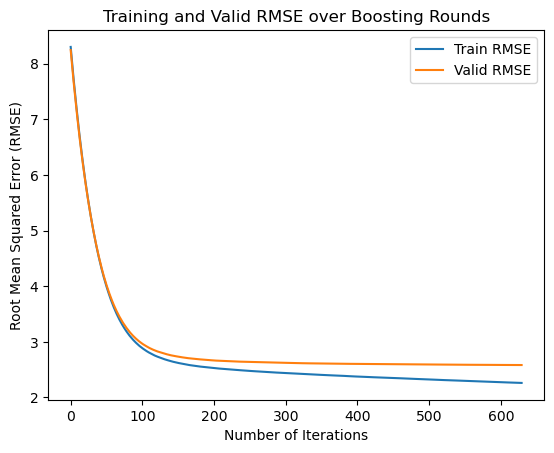

[0]	validation_0-rmse:8.29390	validation_1-rmse:8.32874
[1]	validation_0-rmse:8.14742	validation_1-rmse:8.18311
[2]	validation_0-rmse:8.00365	validation_1-rmse:8.04038
[3]	validation_0-rmse:7.86311	validation_1-rmse:7.90059
[4]	validation_0-rmse:7.72798	validation_1-rmse:7.76601
[5]	validation_0-rmse:7.59657	validation_1-rmse:7.63553
[6]	validation_0-rmse:7.46594	validation_1-rmse:7.50587
[7]	validation_0-rmse:7.34075	validation_1-rmse:7.38113
[8]	validation_0-rmse:7.21544	validation_1-rmse:7.25647
[9]	validation_0-rmse:7.09348	validation_1-rmse:7.13520
[10]	validation_0-rmse:6.97393	validation_1-rmse:7.01612
[11]	validation_0-rmse:6.85697	validation_1-rmse:6.89962
[12]	validation_0-rmse:6.74321	validation_1-rmse:6.78725
[13]	validation_0-rmse:6.63345	validation_1-rmse:6.67821
[14]	validation_0-rmse:6.52588	validation_1-rmse:6.57116
[15]	validation_0-rmse:6.41984	validation_1-rmse:6.46707
[16]	validation_0-rmse:6.31754	validation_1-rmse:6.36515
[17]	validation_0-rmse:6.21651	validation

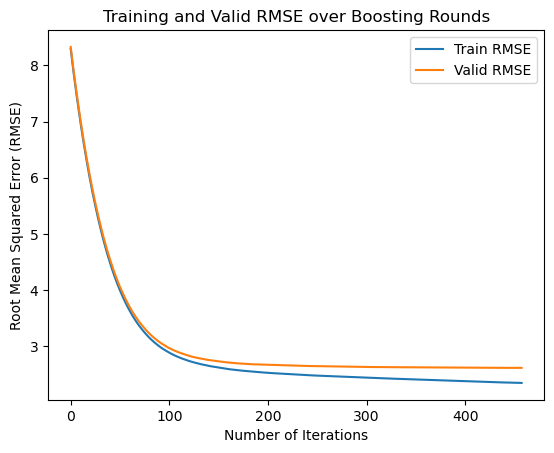

[0]	validation_0-rmse:8.27906	validation_1-rmse:8.46132
[1]	validation_0-rmse:8.13295	validation_1-rmse:8.31134
[2]	validation_0-rmse:7.98912	validation_1-rmse:8.16343
[3]	validation_0-rmse:7.84916	validation_1-rmse:8.01924
[4]	validation_0-rmse:7.71524	validation_1-rmse:7.88167
[5]	validation_0-rmse:7.58434	validation_1-rmse:7.74874
[6]	validation_0-rmse:7.45327	validation_1-rmse:7.61377
[7]	validation_0-rmse:7.32827	validation_1-rmse:7.48625
[8]	validation_0-rmse:7.20350	validation_1-rmse:7.35807
[9]	validation_0-rmse:7.08185	validation_1-rmse:7.23331
[10]	validation_0-rmse:6.96286	validation_1-rmse:7.11094
[11]	validation_0-rmse:6.84645	validation_1-rmse:6.99133
[12]	validation_0-rmse:6.73304	validation_1-rmse:6.87518
[13]	validation_0-rmse:6.62355	validation_1-rmse:6.76257
[14]	validation_0-rmse:6.51706	validation_1-rmse:6.65309
[15]	validation_0-rmse:6.41129	validation_1-rmse:6.54454
[16]	validation_0-rmse:6.30944	validation_1-rmse:6.43991
[17]	validation_0-rmse:6.20844	validation

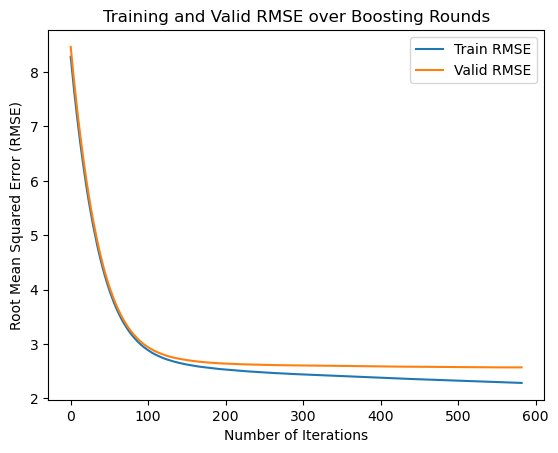

[0]	validation_0-rmse:8.33084	validation_1-rmse:7.97964
[1]	validation_0-rmse:8.18368	validation_1-rmse:7.83797
[2]	validation_0-rmse:8.03892	validation_1-rmse:7.69786
[3]	validation_0-rmse:7.89814	validation_1-rmse:7.56153
[4]	validation_0-rmse:7.76303	validation_1-rmse:7.43224
[5]	validation_0-rmse:7.63091	validation_1-rmse:7.30367
[6]	validation_0-rmse:7.49885	validation_1-rmse:7.17653
[7]	validation_0-rmse:7.37213	validation_1-rmse:7.05342
[8]	validation_0-rmse:7.24604	validation_1-rmse:6.93145
[9]	validation_0-rmse:7.12305	validation_1-rmse:6.81327
[10]	validation_0-rmse:7.00339	validation_1-rmse:6.69826
[11]	validation_0-rmse:6.88590	validation_1-rmse:6.58478
[12]	validation_0-rmse:6.77135	validation_1-rmse:6.47411
[13]	validation_0-rmse:6.66072	validation_1-rmse:6.36720
[14]	validation_0-rmse:6.55308	validation_1-rmse:6.26320
[15]	validation_0-rmse:6.44638	validation_1-rmse:6.16048
[16]	validation_0-rmse:6.34381	validation_1-rmse:6.06138
[17]	validation_0-rmse:6.24187	validation

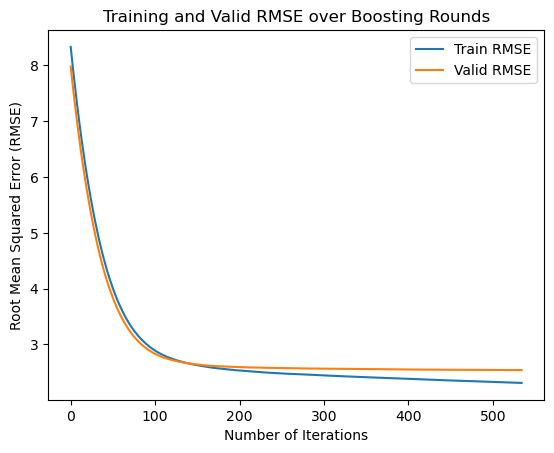

[0]	validation_0-rmse:8.26818	validation_1-rmse:8.55962
[1]	validation_0-rmse:8.12195	validation_1-rmse:8.41086
[2]	validation_0-rmse:7.97835	validation_1-rmse:8.26442
[3]	validation_0-rmse:7.83830	validation_1-rmse:8.12177
[4]	validation_0-rmse:7.70402	validation_1-rmse:7.98550
[5]	validation_0-rmse:7.57326	validation_1-rmse:7.85271
[6]	validation_0-rmse:7.44270	validation_1-rmse:7.71996
[7]	validation_0-rmse:7.31756	validation_1-rmse:7.59325
[8]	validation_0-rmse:7.19242	validation_1-rmse:7.46561
[9]	validation_0-rmse:7.07032	validation_1-rmse:7.34160
[10]	validation_0-rmse:6.95150	validation_1-rmse:7.21983
[11]	validation_0-rmse:6.83521	validation_1-rmse:7.10242
[12]	validation_0-rmse:6.72131	validation_1-rmse:6.98703
[13]	validation_0-rmse:6.61103	validation_1-rmse:6.87504
[14]	validation_0-rmse:6.50425	validation_1-rmse:6.76637
[15]	validation_0-rmse:6.39813	validation_1-rmse:6.65832
[16]	validation_0-rmse:6.29588	validation_1-rmse:6.55451
[17]	validation_0-rmse:6.19484	validation

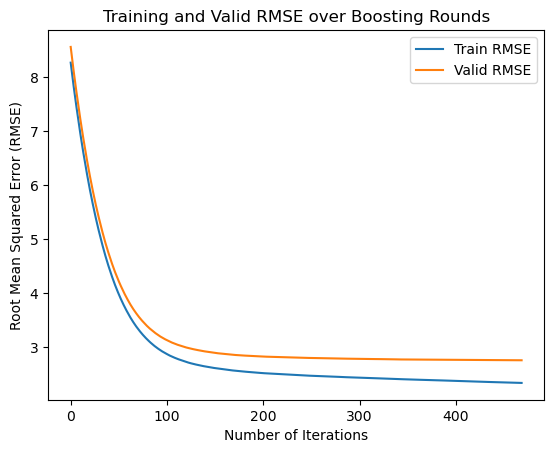

In [ ]:
# from sklearn.model_selection import train_test_split
print(data_train_test_dir)
for subset_name, subset_features in predictor_subsets.items():
    print(subset_name)
    model_path = (save_dir ) /"bayes"/ "model.pkl"
    print(model_path)

    with open(model_path, 'rb') as f:
        reg = pkl.load(f)
    print(reg)

    # 10 fold model evaluation
    for i in range(1,11):
        train = pd.read_csv(data_train_test_dir / f"train{i}.csv", index_col=0).dropna(subset=[y_col])
        test = pd.read_csv(data_train_test_dir / f"test{i}.csv", index_col=0).dropna(subset=[y_col])
        train = add_time_vars(train)
        X_train = train[subset_features]
        y_train = train[y_col]
        test = add_time_vars(test)
        X_test = test[subset_features]
        y_test = test[y_col]
        
        # X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
        reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], early_stopping_rounds=10)
        results = reg.evals_result()
        plt.plot(results['validation_0']['rmse'], label='Train RMSE')
        plt.plot(results['validation_1']['rmse'], label='Valid RMSE')
        plt.xlabel('Number of Iterations')
        plt.ylabel('Root Mean Squared Error (RMSE)')
        plt.legend()
        plt.title('Training and Valid RMSE over Boosting Rounds')
        plt.savefig(learning_curve_dir / ( f'_learning_curve{i}.png'))
        plt.show()
        
        # test performance
        y_test_pred = reg.predict(X_test)
        scores = compute_performance_metrics(y_test, y_test_pred)
        scores_df = pd.DataFrame(scores, index=[0])
        scores_df.to_csv(test_performance_dir / ( f"_test_performance{i}.csv"), index=False)

        # test prediction
        test['XGB_NEE_U50_fall'] = y_test_pred
        test['XGB_NEE_U50_f'] = np.where(test[y_col].notnull(), test[y_col], test['XGB_NEE_U50_fall'])
        test.to_csv(test_prediction_dir / (f"_test_prediction{i}.csv"), index=False)


# Step 4: Feature importance

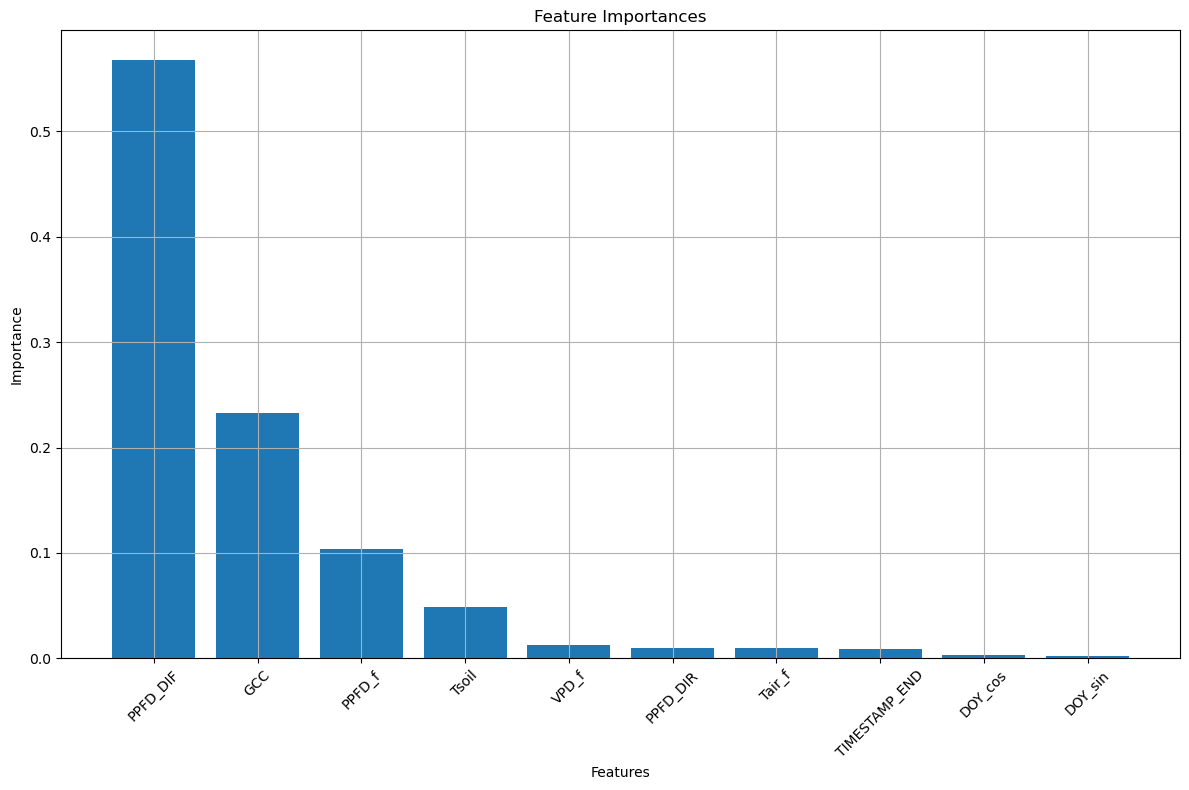

In [47]:
import pickle as pickle
feature_importance_df = pd.DataFrame()
import pickle   
model_path = (save_dir) / "model.pkl"  
with open(model_path, 'rb') as f:
    reg = pickle.load(f)

X = site_data_no_na[subset_features]
y = site_data_no_na[y_col] 
reg.fit(X, y)
feature_importance_df['Feature_Importances'] = reg.feature_importances_
feature_importance_df['subset_features'] = subset_features
# Sort by feature importances
feature_importance_df = feature_importance_df.sort_values(by='Feature_Importances', ascending=False)
feature_importance_df
feature_importance_df.to_csv(site_data_dir / "feature_importances_FC_BART_AmeriFlux.csv", index=False)

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.bar(feature_importance_df['subset_features'], feature_importance_df['Feature_Importances'])
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 5: Test performance

In [48]:
print(test_performance_dir)
# for GCC + Base as predictors
csv_files = [
    os.path.join(test_performance_dir, file) 
    for file in os.listdir(test_performance_dir) 
    if file.startswith('03') and file.endswith('.csv')
]
csv_list = [pd.read_csv(file) for file in csv_files]
csv_dict = {os.path.basename(file): pd.read_csv(file) for file in csv_files}
combined_data = pd.concat(csv_list, ignore_index=True)
combined_data

F:\13 Gapfill_since_2017\BART_AmeriFlux\FC_test_performance


,mse,mae,nmae,r2,pr2,bias
0,7.900247,1.836213,0.242240,0.862505,0.863015,-0.038291
1,7.216234,1.769546,0.240325,0.866898,0.866920,0.015965
2,7.115852,1.759954,0.231325,0.877067,0.877289,-0.012178
3,7.306897,1.788084,0.238730,0.869752,0.869851,0.007784
4,7.035007,1.779159,0.239884,0.872110,0.872330,0.017995
5,7.194112,1.773529,0.236864,0.871679,0.872050,0.019645
6,7.334089,1.795303,0.238610,0.870447,0.870992,0.116781
7,7.151252,1.770573,0.233818,0.875288,0.875427,0.050489
8,6.890322,1.749273,0.240113,0.870176,0.870187,-0.019254
9,8.132268,1.849717,0.240524,0.862495,0.862815,0.013232


model performance on test set
RMSE is 2.71 ± 0.07
R2 is 0.870 ± 0.005
Bias is 0.0172 ± 0.0405


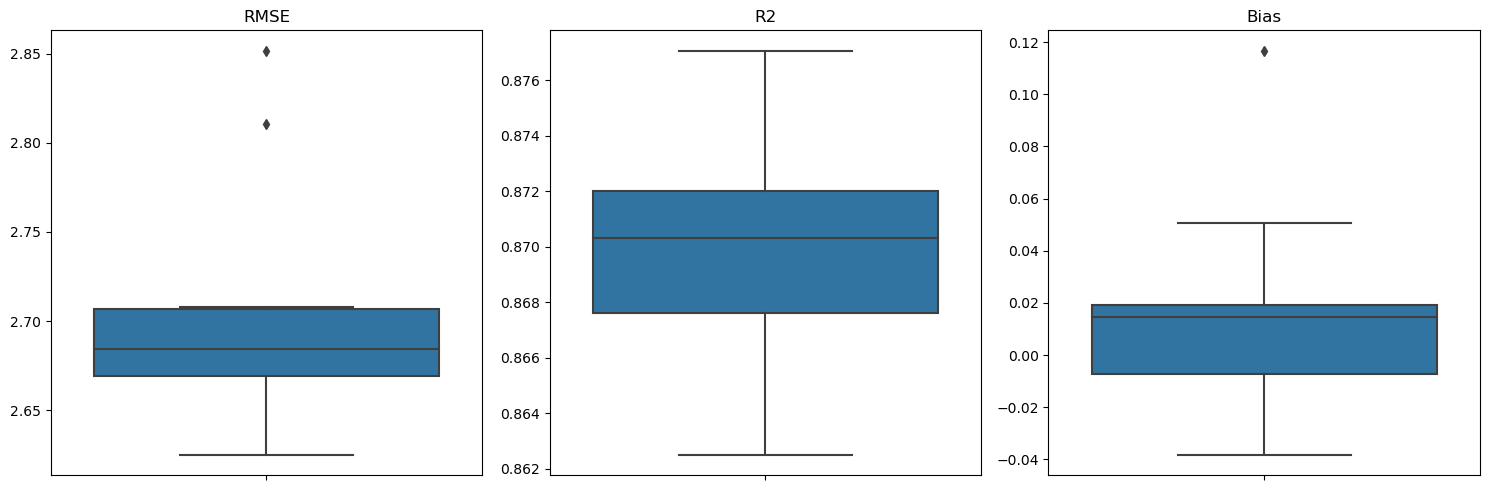

<Figure size 640x480 with 0 Axes>

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate the mean and standard deviation for RMSE
rmse_mean = np.mean(np.sqrt(combined_data['mse']))
rmse_sd = np.std(np.sqrt(combined_data['mse']))

# Calculate the mean and standard deviation for R2
r2_mean = np.mean(combined_data['r2'])
r2_sd = np.std(combined_data['r2'])

# Calculate the mean and standard deviation for Bias
bias_mean = np.mean(combined_data['bias'])
bias_sd = np.std(combined_data['bias'])

# Print the results
print("model performance on test set")
print(f"RMSE is {rmse_mean:.2f} ± {rmse_sd:.2f}")
print(f"R2 is {r2_mean:.3f} ± {r2_sd:.3f}")
print(f"Bias is {bias_mean:.4f} ± {bias_sd:.4f}")

# Set up the figure and axes
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# RMSE Boxplot
sns.boxplot(y=np.sqrt(combined_data['mse']), ax=axes[0])
axes[0].set_title('RMSE')
axes[0].set_ylabel('')
axes[0].tick_params(axis='y', rotation=0)

# R2 Boxplot
sns.boxplot(y=combined_data['r2'], ax=axes[1])
axes[1].set_title('R2')
axes[1].set_ylabel('')
axes[1].tick_params(axis='y', rotation=0)

# Bias Boxplot
sns.boxplot(y=combined_data['bias'], ax=axes[2])
axes[2].set_title('Bias')
axes[2].set_ylabel('')
axes[2].tick_params(axis='y', rotation=0)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
plt.savefig(os.path.join(test_performance_dir, "test_performance_using_GCC"))

# Step 6: Annual sum

In [50]:
def agg_by_year(data, data_var_name, start_year, end_year):
    
    import pandas as pd
    # Initialize an empty dataframe to store aggregated data
    agg_data = pd.DataFrame()

    # Define molar mass of CO2 in g/mol
    molar_mass = 12.011

    # Define a function to get the number of days in a year
    def get_days_in_year(year):
        import calendar
        return 366 if calendar.isleap(year) else 365

    # Iterate over years from start_year to end_year
    for i in range(start_year, end_year + 1):
        # Subset data for the current year
        data_sub = data[data['Year'] == i]
        
        # Extract data variable
        half_hour = data_sub[data_var_name]
        
        # Calculate mean CO2 value
        agg_co2 = half_hour.mean(skipna=True)
        
        # Calculate aggregated value
        agg = agg_co2 * 1e-6 * molar_mass * 3600 * 24 * get_days_in_year(i)
        
        # Append to agg_data dataframe
        agg_data = agg_data.append(pd.DataFrame({'Year': [i], 'annual_sum': [agg]}), ignore_index=True)

    return agg_data

In [51]:
print(all_prediction_dir)
file_path = f"{all_prediction_dir}/03_GCC+Base_all_prediction.csv"
df = pd.read_csv(file_path)
agg_data = agg_by_year(df, "XGB_NEE_U50_f", 2017, 2022)

output_file_path = site_data_dir / "annual_sum_FC_BART_AmeriFlux.csv"
agg_data.to_csv(output_file_path, index=False)
agg_data

F:\13 Gapfill_since_2017\BART_AmeriFlux\FC_accurate_prediction


,Year,annual_sum
0,2017,-39.520044
1,2018,3.814031
2,2019,-110.311830
3,2020,-7.194618
4,2021,18.926119
5,2022,86.789574


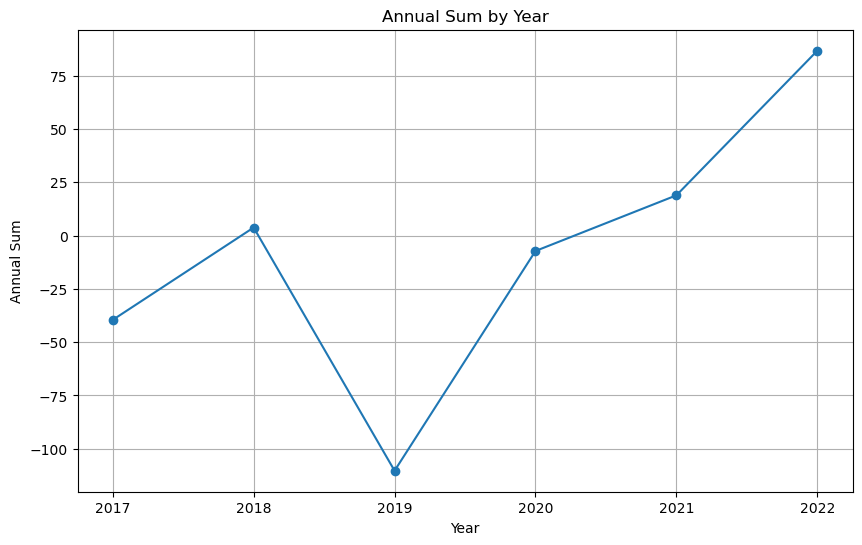

In [52]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(agg_data['Year'], agg_data['annual_sum'], marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Annual Sum')
plt.title('Annual Sum by Year')
plt.grid(True)
plt.show()

# Step 7: Monthly sum

In [53]:
def agg_by_month(df, var_name, start_year, end_year):
    print("check if you have Month and Year in input data!")
    
    import pandas as pd

    # Initialize an empty DataFrame to store monthly sums
    monthly_df = pd.DataFrame(columns=['Year', 'Month', 'monthly_sum'])
    
    # Define molar mass of CO2 in g/mol
    molar_mass = 12.011

    # Define a function to get the number of days in a month
    def get_days_in_month(year, month):
        import calendar
        return calendar.monthrange(year, month)[1]

    # Filter data for the specified range of years
    df = df[(df['Year'] >= start_year) & (df['Year'] <= end_year)]

    # Iterate over unique years in the DataFrame
    for year in range(start_year, end_year + 1):
        # Iterate over months (1 to 12)
        for month in range(1, 13):
            # Subset DataFrame for the current year and month
            df_sub = df[(df['Year'] == year) & (df['Month'] == month)]
            
            # Extract data variable
            half_hour = df_sub[var_name]
            
            # Calculate mean CO2 value
            agg_co2 = half_hour.mean(skipna=True)
            
            # Calculate aggregated value
            days_in_month = get_days_in_month(year, month)
            agg = agg_co2 * 1e-6 * molar_mass * 3600 * 24 * days_in_month
            
            # Append result to monthly_df DataFrame
            monthly_df = monthly_df.append({'Year': year, 'Month': month, 'monthly_sum': agg}, ignore_index=True)
    
    return monthly_df

In [54]:
agg_data = agg_by_month(df, "XGB_NEE_U50_f", 2017, 2022)
output_file_path = site_data_dir / "monthly_sum_FC_AmeriFlux.csv"
agg_data.to_csv(output_file_path, index=False)
agg_data

check if you have Month and Year in input data!


,Year,Month,monthly_sum
0,2017.0,1.0,36.933302
1,2017.0,2.0,32.751449
2,2017.0,3.0,35.637920
3,2017.0,4.0,28.919968
4,2017.0,5.0,-7.287919
...,...,...,...
67,2022.0,8.0,-32.734512
68,2022.0,9.0,-4.023666
69,2022.0,10.0,84.056724
70,2022.0,11.0,69.412810


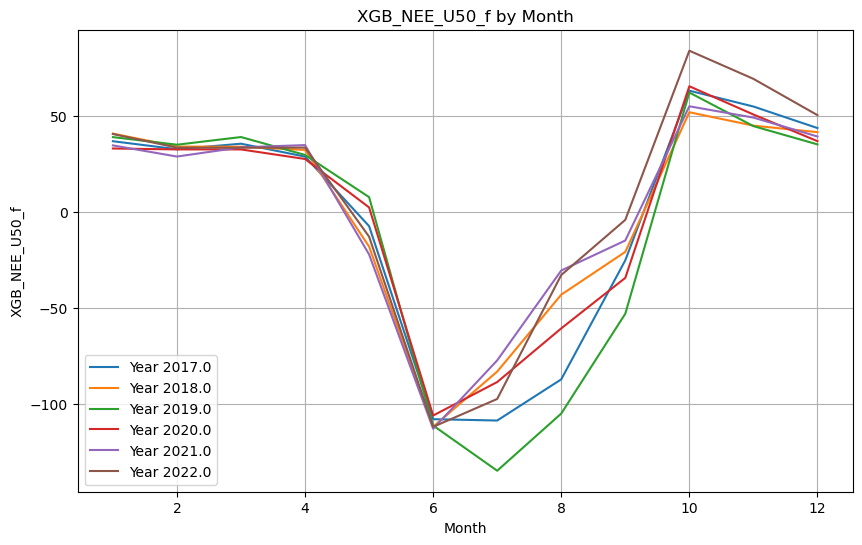

In [55]:
# Plot the results
plt.figure(figsize=(10, 6))

# Iterate over unique years in the DataFrame
for year in agg_data['Year'].unique():
    # Filter data for the current year
    year_data = agg_data[agg_data['Year'] == year]
    # Plot XGB_NEE_U50_f by Month, with different colors for each Year
    plt.plot(year_data['Month'], year_data['monthly_sum'], label=f'Year {year}')

plt.xlabel('Month')
plt.ylabel('XGB_NEE_U50_f')
plt.title('XGB_NEE_U50_f by Month')
plt.legend()
plt.grid(True)

plt.savefig(os.path.join(site_data_dir, "AmeriFlux_NEE_monthly_sum.png"))
plt.show()